In [1]:
# Import semua pustaka yang akan digunakan
import os
import re
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("✅ Pustaka berhasil diinstal dan diimpor.")

✅ Pustaka berhasil diinstal dan diimpor.


In [6]:
# Cell 2: Konfigurasi Path dan Folder

# Tentukan folder input dan output
# Ganti path ini sesuai dengan struktur folder di komputer Anda
input_folder = os.path.join('data_putusan', 'dok_putusan_txt')
output_folder = 'hasil_ringkasan_detailed'

# Buat folder output jika belum ada
os.makedirs(output_folder, exist_ok=True)

print(f"Folder input diatur ke: '{input_folder}'")
print(f"Hasil ringkasan akan disimpan di: '{output_folder}'")

Folder input diatur ke: 'data_putusan\dok_putusan_txt'
Hasil ringkasan akan disimpan di: 'hasil_ringkasan_detailed'


In [7]:
# Cell 3: Memuat Satu Dokumen untuk Analisis Mendalam

# Pilih satu file untuk dianalisis, misalnya 'doc01.txt'
file_untuk_analisis = 'doc01.txt'
path_file_analisis = os.path.join(input_folder, file_untuk_analisis)

# Baca konten file
try:
    with open(path_file_analisis, 'r', encoding='utf-8') as file:
        original_text = file.read()
    print(f"Berhasil memuat file: '{file_untuk_analisis}'")
    print("\n--- Cuplikan Isi Teks Asli (500 karakter pertama) ---")
    print(original_text[:500])
except FileNotFoundError:
    print(f"Error: File '{path_file_analisis}' tidak ditemukan. Periksa kembali path Anda.")
    original_text = ""

Berhasil memuat file: 'doc01.txt'

--- Cuplikan Isi Teks Asli (500 karakter pertama) ---
ep  P U T U SN Nomor 5/Pid.Sus/2020/PN Kag  DEMI KEADILAN BERDASARKAN KETUHANAN YANG MAHA ESA  Pengadilan Negeri Kayuagung yang mengadili perkara pidana dengan  acara pemeriksaan biasa dalam tingkat pertama menjatuhkan putusan sebagai berikut dalam perkara Terdakwa :  Tempat lahir  : Palembang  Umur/Tanggal lahir  : 34 Tahun / 24 April 1985  Jenis kelamin  : Laki-laki  Kebangsaan  : Indonesia  Tempat tinggal  : Jl. Tangga Takat No. 1029 Rt. 17 Rw. 07 Kel. Tangga ub lik  : KA Ibrahim Bin KH Abdul


In [8]:
# Cell 4: Tahap 1 - Text Preprocessing

# 1. Segmentasi menjadi kalimat
cleaned_text_for_sentences = original_text.replace('\n', ' ').replace('  ', ' ')
sentences = [s.strip() + '.' for s in cleaned_text_for_sentences.split('.') if s.strip()]
print(f"Jumlah kalimat dalam dokumen asli: {len(sentences)}")

# 2. Inisialisasi Sastrawi
stemmer = StemmerFactory().create_stemmer()
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()

# 3. Proses stemming dan stopword removal
preprocessed_sentences = [stopword_remover.remove(stemmer.stem(s)) for s in sentences]

# Tampilkan perbandingan sebelum dan sesudah preprocessing
print("\n--- Contoh Perbandingan Preprocessing ---")
print(f"Kalimat Asli [0]:\n{sentences[0]}\n")
print(f"Kalimat Setelah Preprocessing [0]:\n{preprocessed_sentences[0]}")

Jumlah kalimat dalam dokumen asli: 334

--- Contoh Perbandingan Preprocessing ---
Kalimat Asli [0]:
ep P U T U SN Nomor 5/Pid.

Kalimat Setelah Preprocessing [0]:
ep p u t u sn nomor 5 pid


In [9]:
# Cell 5: Tahap 2 - Vectorization dengan TF-IDF

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_sentences)

# Tampilkan hasil matriks TF-IDF dalam bentuk yang mudah dibaca (DataFrame)
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=[f'Kalimat {i+1}' for i in range(len(sentences))])

print("Ukuran Matriks TF-IDF (Kalimat x Kosakata Unik):", df_tfidf.shape)
print("\n--- Contoh Matriks TF-IDF ---")
# Tampilkan beberapa baris dan kolom pertama untuk melihat skor
df_tfidf.iloc[:5, :10]

Ukuran Matriks TF-IDF (Kalimat x Kosakata Unik): (334, 634)

--- Contoh Matriks TF-IDF ---


,00,000,01,07,0895604331314,10,1029,11,112,114
Kalimat 1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Kalimat 2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Kalimat 3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Kalimat 4,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0
Kalimat 5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Ukuran Matriks Kemiripan: (334, 334)


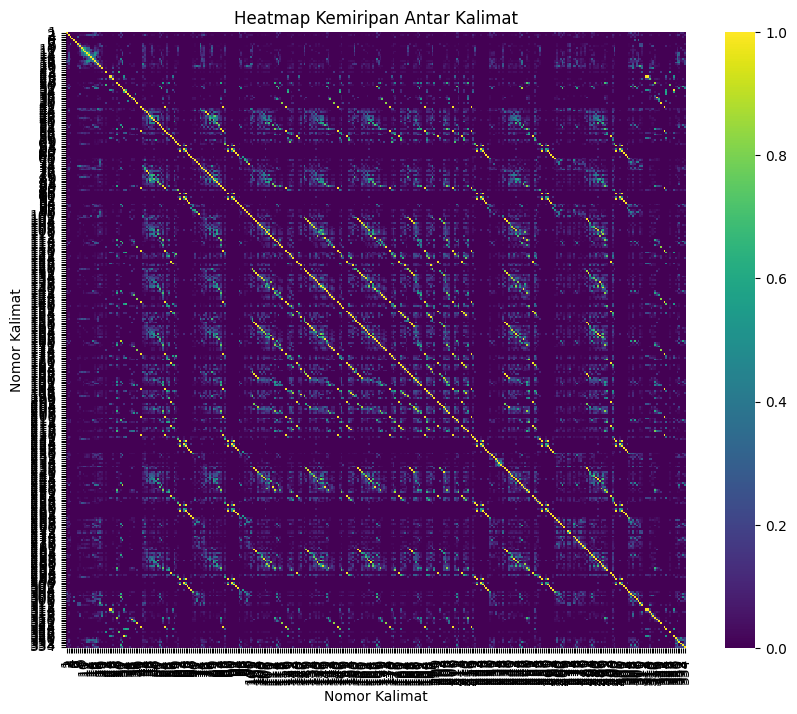

In [10]:
# Cell 6: Tahap 3 - Menghitung Kemiripan Antar Kalimat (Cosine Similarity)

similarity_matrix = cosine_similarity(tfidf_matrix)

print("Ukuran Matriks Kemiripan:", similarity_matrix.shape)

# Visualisasikan matriks kemiripan menggunakan heatmap untuk pemahaman yang lebih baik
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap='viridis', xticklabels=range(1, len(sentences)+1), yticklabels=range(1, len(sentences)+1))
plt.title('Heatmap Kemiripan Antar Kalimat')
plt.xlabel('Nomor Kalimat')
plt.ylabel('Nomor Kalimat')
plt.show()

In [11]:
# Cell 7: Tahap 4 - Membangun Graf dan Menjalankan TextRank

# Membuat graf dari matriks kemiripan
graph = nx.from_numpy_array(similarity_matrix)

# Menjalankan algoritma PageRank untuk mendapatkan skor TextRank
scores = nx.pagerank(graph)

print("Skor TextRank untuk setiap kalimat berhasil dihitung.")
# Tampilkan beberapa skor awal
for i in range(5):
    print(f"Skor Kalimat {i+1}: {scores[i]:.4f}")

Skor TextRank untuk setiap kalimat berhasil dihitung.
Skor Kalimat 1: 0.0015
Skor Kalimat 2: 0.0025
Skor Kalimat 3: 0.0014
Skor Kalimat 4: 0.0032
Skor Kalimat 5: 0.0013


In [12]:
# Cell 8: Analisis Skor dan Peringkat Kalimat

# Gabungkan kalimat asli, skor, dan urutan ke dalam DataFrame
df_scores = pd.DataFrame({
    'No. Kalimat': range(1, len(sentences) + 1),
    'Kalimat': sentences,
    'Skor TextRank': [scores[i] for i in range(len(sentences))]
})

# Urutkan DataFrame berdasarkan skor tertinggi
df_sorted = df_scores.sort_values(by='Skor TextRank', ascending=False)

print("--- Peringkat Kalimat Berdasarkan Skor TextRank Tertinggi ---")
display(df_sorted.head(10)) # Tampilkan 10 kalimat dengan skor tertinggi

# Analisis kalimat dengan skor tertinggi
top_sentence_index = df_sorted.index[0]
print(f"\nANALISIS KALIMAT DENGAN SKOR TERTINGGI (Kalimat No. {top_sentence_index + 1}):")
print(f"Kalimat: \"{sentences[top_sentence_index]}\"")
print(f"Skor: {scores[top_sentence_index]:.4f}")
print("Alasan kemungkinan terpilih:")
print("1. Kalimat ini kemungkinan besar mengandung kata-kata kunci yang juga muncul di banyak kalimat lain.")
print("2. Jika Anda melihat baris/kolom pada heatmap di Cell 6, baris/kolom yang sesuai dengan nomor kalimat ini cenderung lebih terang, menandakan ia memiliki kemiripan tinggi dengan banyak kalimat lain.")
print("3. Ia bertindak sebagai 'jembatan' yang menghubungkan beberapa topik atau detail penting dalam teks.")

--- Peringkat Kalimat Berdasarkan Skor TextRank Tertinggi ---


,No. Kalimat,Kalimat,Skor TextRank
294,295,000 (tiga juta Sembilan ratus) dan terdakwa be...,0.005895
252,253,000 (tiga juta Sembilan ratus) dan terdakwa be...,0.005710
79,80,30 wib saksi Eksa Mahyudi dan saksi Benny Wiry...,0.005565
204,205,- Bahwa pada awalnya saksi Laila bersama terda...,0.005541
52,53,10 wib saksi Laila digeledah oleh Polisi Wanit...,0.005514
188,189,Bahwa pada awalnya saksi bersama terdakwa seda...,0.005385
194,195,000 (dua juta sembilan ratus dua puluh tujuh r...,0.005328
284,285,Sus/2020/PN Kag d tunggal ada peredaran Narkot...,0.005296
282,283,"Ogan Ilir, terdakwa dan saksi keterangan saksi...",0.005242
163,164,30 wib saksi Eksa dan saksi Benny melakukan pe...,0.005171



ANALISIS KALIMAT DENGAN SKOR TERTINGGI (Kalimat No. 295):
Kalimat: "000 (tiga juta Sembilan ratus) dan terdakwa bersama saksi Laila telah menjual pil ekstasi sebanyak 10½ (sepuluh setengah) butir di acara orgen tunggal golden star tersebut; Menimbang, bahwa terdakwa tidak memiliki izin dari pihak yang berwenang untuk menjual Narkotika jenis pil ekstasi tersebut; Menimbang, bahwa berdasarkan pemeriksaan di laboratorium forensik cabang Palembang dengan NO."
Skor: 0.0059
Alasan kemungkinan terpilih:
1. Kalimat ini kemungkinan besar mengandung kata-kata kunci yang juga muncul di banyak kalimat lain.
2. Jika Anda melihat baris/kolom pada heatmap di Cell 6, baris/kolom yang sesuai dengan nomor kalimat ini cenderung lebih terang, menandakan ia memiliki kemiripan tinggi dengan banyak kalimat lain.
3. Ia bertindak sebagai 'jembatan' yang menghubungkan beberapa topik atau detail penting dalam teks.


In [13]:
# Cell 9: Tahap 5 - Menghasilkan dan Menyimpan Ringkasan Final

# Ambil kalimat-kalimat dengan skor tertinggi dari DataFrame yang sudah diurutkan
compression_rate = 0.75
num_sentences_in_summary = int(len(sentences) * (1 - compression_rate))
if num_sentences_in_summary < 1: num_sentences_in_summary = 1

# Ambil kalimat teratas
top_sentences_df = df_sorted.head(num_sentences_in_summary)

# Urutkan kembali berdasarkan urutan asli dalam teks agar ringkasan lebih koheren
summary_sentences = top_sentences_df.sort_index()['Kalimat'].tolist()
summary_result = " ".join(summary_sentences)

# Simpan hasil
output_path = os.path.join(output_folder, f"{os.path.splitext(file_untuk_analisis)[0]}_ringkasan.txt")
with open(output_path, 'w', encoding='utf-8') as file:
    file.write(summary_result)

print(f"--- RINGKASAN FINAL (Disimpan di {output_path}) ---")
print(summary_result)

--- RINGKASAN FINAL (Disimpan di hasil_ringkasan_detailed\doc01_ringkasan.txt) ---
Menyatakan barang bukti berupa : - 10 ½ (sepuluh setengah) butir pil ekstasi dengan rincian 6 ½ (enam lik setengah) butir Pil ekstasi warna cream bentuk tablet segi empat panjang logo gold yang dibungkus plastik bening dan 4 butir pil ekstasi warna cream bentuk tablet segi empat panjang logo gold yang dibalut plastik 5. 000,- (dua juta sembilan ratus dua   Halaman 2 mendengar permohonan Terdakwa yang Setelah  pada pokoknya menyatakan Terdakwa memohon agar dijatuhkan hukuman yang seringan- ringannya ; Setelah mendengar tanggapan Penuntut Umum terhadap permohonan Terdakwa yang pada pokoknya tetap pada tuntutannya ; Menimbang, bahwa Terdakwa diajukan ke persidangan oleh Penuntut Umum, dengan surat dakwaan sebagai berikut : DAKWAAN Bahwa terdakwa KA IBRAHIM BIN KH ABDULLAH MUROD, pada hari ub lik Kamis, tanggal 26 September 2019 sekira jam 00. 30 Wib atau setidak-tidaknya pada suatu waktu dalam bulan Septemb

In [14]:
len(summary_result)

21658

In [15]:
# Cell 10: Skrip Final - Menerapkan ke Semua Dokumen

def summarize_text_file(input_path, output_path, compression_rate=0.75):
    """Fungsi lengkap untuk membaca, meringkas, dan menyimpan satu file."""
    with open(input_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Preprocessing
    sentences = [s.strip() + '.' for s in text.replace('\n', ' ').split('.') if s.strip()]
    if not sentences: return
    
    preprocessed = [stopword_remover.remove(stemmer.stem(s)) for s in sentences]

    # Vectorization & Similarity
    vectorizer = TfidfVectorizer()
    try:
        tfidf_matrix = vectorizer.fit_transform(preprocessed)
    except ValueError:
        return # Skip file jika tidak ada kata setelah preprocessing
        
    sim_matrix = cosine_similarity(tfidf_matrix)

    # TextRank
    graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(graph)

    # Summarization
    ranked = sorted(((scores[i], s, i) for i, s in enumerate(sentences)), reverse=True)
    count = int(len(sentences) * (1 - compression_rate))
    if count < 1: count = 1
    
    top_ranked = ranked[:count]
    # Urutkan kembali sesuai urutan asli
    top_ranked_sorted_by_index = sorted(top_ranked, key=lambda x: x[2])
    summary = " ".join([sentence for score, sentence, index in top_ranked_sorted_by_index])

    # Save
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(summary)
    print(f"✅ Ringkasan untuk {os.path.basename(input_path)} disimpan.")


# Loop untuk memproses semua file
print("\n--- MEMPROSES SEMUA DOKUMEN DI FOLDER INPUT ---")
all_files = os.listdir(input_folder)
for filename in all_files:
    if filename.endswith('.txt'):
        in_path = os.path.join(input_folder, filename)
        out_filename = f"{os.path.splitext(filename)[0]}_ringkasan.txt"
        out_path = os.path.join(output_folder, out_filename)
        summarize_text_file(in_path, out_path)

print("\n--- SEMUA PROSES SELESAI ---")


--- MEMPROSES SEMUA DOKUMEN DI FOLDER INPUT ---
✅ Ringkasan untuk doc01.txt disimpan.
✅ Ringkasan untuk doc02.txt disimpan.
✅ Ringkasan untuk doc03.txt disimpan.
✅ Ringkasan untuk doc04.txt disimpan.
✅ Ringkasan untuk doc05.txt disimpan.
✅ Ringkasan untuk doc06.txt disimpan.
✅ Ringkasan untuk doc07.txt disimpan.
✅ Ringkasan untuk doc08.txt disimpan.
✅ Ringkasan untuk doc09.txt disimpan.
✅ Ringkasan untuk doc10.txt disimpan.
✅ Ringkasan untuk doc11.txt disimpan.
✅ Ringkasan untuk doc12.txt disimpan.
✅ Ringkasan untuk doc13.txt disimpan.
✅ Ringkasan untuk doc14.txt disimpan.
✅ Ringkasan untuk doc15.txt disimpan.
✅ Ringkasan untuk doc16.txt disimpan.
✅ Ringkasan untuk doc17.txt disimpan.
✅ Ringkasan untuk doc18.txt disimpan.
✅ Ringkasan untuk doc19.txt disimpan.
✅ Ringkasan untuk doc20.txt disimpan.
✅ Ringkasan untuk doc21.txt disimpan.
✅ Ringkasan untuk doc22.txt disimpan.
✅ Ringkasan untuk doc23.txt disimpan.
✅ Ringkasan untuk doc24.txt disimpan.
✅ Ringkasan untuk doc25.txt disimpan.
✅